In [1]:
import pandas as pd
import numpy as np
path = '../data/'
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
viz_path = '../viz/'
from utils import *
from network import *
from geo_exploration import *

In [2]:
df = load_data(path)
df = preprocess(df)



/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'], format='ISO8601')
/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_started'] = df['started_at'].dt.year
/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [3]:
df

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,hour_started,minute_started,second_started,year_ended,month_ended,day_ended,weekday_ended,hour_ended,minute_ended,second_ended
295082,11AA3AB3ED9FEFC5,classic_bike,2022-01-01 00:10:20,2022-01-01 00:19:29,Riverview Park,JC057,Riverview Park,JC057,40.744319,-74.043991,...,0,10,20,2022,1,1,5,0,19,29
312873,554FD61E00599BE2,electric_bike,2022-01-01 00:10:24,2022-01-01 00:14:06,Sip Ave,JC056,Glenwood Ave,JC094,40.730897,-74.063913,...,0,10,24,2022,1,1,5,0,14,6
312934,4D3D324F756B7103,electric_bike,2022-01-01 00:10:28,2022-01-01 00:14:12,Sip Ave,JC056,Glenwood Ave,JC094,40.730897,-74.063913,...,0,10,28,2022,1,1,5,0,14,12
295511,E26BB19DBC834216,classic_bike,2022-01-01 00:10:30,2022-01-01 00:24:30,Grove St PATH,JC005,Newport Pkwy,JC008,40.719586,-74.043117,...,0,10,30,2022,1,1,5,0,24,30
298413,DC18B042AA415411,classic_bike,2022-01-01 00:11:31,2022-01-01 00:30:43,Columbus Dr at Exchange Pl,JC106,Columbus Dr at Exchange Pl,JC106,40.716870,-74.032810,...,0,11,31,2022,1,1,5,0,30,43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49840,B41EB02871B99E34,classic_bike,2024-04-30 23:36:20,2024-04-30 23:38:15,Newark Ave,JC032,Jersey & 6th St,JC027,40.721525,-74.046305,...,23,36,20,2024,4,30,1,23,38,15
39859,AD14D110757EAC72,electric_bike,2024-04-30 23:41:50,2024-04-30 23:46:59,9 St HBLR - Jackson St & 8 St,HB305,Church Sq Park - 5 St & Park Ave,HB601,40.748099,-74.038417,...,23,41,50,2024,4,30,1,23,46,59
40621,CF187C42DFB29698,electric_bike,2024-04-30 23:41:55,2024-04-30 23:47:04,9 St HBLR - Jackson St & 8 St,HB305,Church Sq Park - 5 St & Park Ave,HB601,40.747993,-74.038469,...,23,41,55,2024,4,30,1,23,47,4
48338,D4E42712B36E3DEF,classic_bike,2024-04-30 23:48:53,2024-04-30 23:50:35,Newark Ave,JC032,Van Vorst Park,JC035,40.721525,-74.046305,...,23,48,53,2024,4,30,1,23,50,35


In [4]:

def spatial_demand_extraction(df):
    # Create outgoing bikes data
    outgoing = df.groupby(['start_station_name', 'year_started', 'month_started', 'weekday_started', 'hour_started']).size().reset_index(name='outgoing_bikes')

    # Create incoming bikes data
    incoming = df.groupby(['end_station_name', 'year_ended', 'month_ended', 'weekday_ended', 'hour_ended']).size().reset_index(name='incoming_bikes')
 
    outgoing.rename(columns={'start_station_name': 'station_name', 'year_started': 'year', 'month_started': 'month', 'weekday_started': 'weekday', 'hour_started': 'hour'}, inplace=True)
    incoming.rename(columns={'end_station_name': 'station_name', 'year_ended': 'year', 'month_ended': 'month', 'weekday_ended': 'weekday', 'hour_ended': 'hour'}, inplace=True)

    # Merge the dataframes
    demand = pd.merge(outgoing, incoming, how='outer', on=['station_name', 'year', 'month', 'weekday', 'hour'])
    demand.fillna(0, inplace=True)
    demand['net_bikes'] = demand['incoming_bikes'] - demand['outgoing_bikes']
    
    return demand




In [5]:
# Create DataFrames for start and end stations with unified column names
start_stations = df[['start_station_name', 'start_lat', 'start_lng']].rename(
    columns={'start_station_name': 'station_name', 'start_lat': 'lat', 'start_lng': 'lng'}
)

end_stations = df[['end_station_name', 'end_lat', 'end_lng']].rename(
    columns={'end_station_name': 'station_name', 'end_lat': 'lat', 'end_lng': 'lng'}
)
# Concatenate and drop duplicates to get unique stations
all_stations = pd.concat([start_stations, end_stations]).drop_duplicates(subset='station_name').reset_index(drop=True)
# Create dictionary for mapping
station_location_dict = all_stations.set_index('station_name')[['lat', 'lng']].apply(tuple, axis=1).to_dict()


In [6]:
demand = spatial_demand_extraction(df)

In [7]:
# Map both lat and lng using the dictionary of tuples
demand['latitudes'] = demand['station_name'].map(lambda x: station_location_dict.get(x, (None, None))[0])
demand['longitudes'] = demand['station_name'].map(lambda x: station_location_dict.get(x, (None, None))[1])

# demand['longitudes'] = demand['station_name'].map(station_location_mapping.set_index('station_name')['lng'])

In [8]:
demand

,station_name,year,month,weekday,hour,outgoing_bikes,incoming_bikes,net_bikes,latitudes,longitudes
0,1 Ave & E 16 St,2023,5,2,19,0.0,1.0,1.0,40.732219,-73.981656
1,1 Ave & E 30 St,2022,7,2,5,0.0,1.0,1.0,40.735016,-74.027589
2,1 Ave & E 30 St,2023,9,1,8,1.0,1.0,0.0,40.735016,-74.027589
3,1 Ave & E 39 St,2024,1,3,9,0.0,1.0,1.0,40.747140,-73.971130
4,1 Ave & E 39 St,2024,2,3,9,0.0,1.0,1.0,40.747140,-73.971130
...,...,...,...,...,...,...,...,...,...,...
326137,York St & Marin Blvd,2024,4,6,17,5.0,13.0,8.0,40.716615,-74.042412
326138,York St & Marin Blvd,2024,4,6,18,1.0,3.0,2.0,40.716615,-74.042412
326139,York St & Marin Blvd,2024,4,6,19,3.0,2.0,-1.0,40.716615,-74.042412
326140,York St & Marin Blvd,2024,4,6,20,4.0,1.0,-3.0,40.716615,-74.042412


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display

# Define fixed longitude, latitude, and net bike ranges
hour_averaged = demand.groupby(['station_name', 'latitudes', 'longitudes', 'hour'])['net_bikes'].mean().reset_index()
lon_min, lon_max = hour_averaged['longitudes'].min(), hour_averaged['longitudes'].max()
lat_min, lat_max = hour_averaged['latitudes'].min(), hour_averaged['latitudes'].max()
net_bike_min, net_bike_max = hour_averaged['net_bikes'].min(), hour_averaged['net_bikes'].max()

# Create a Normalize instance to fix color scaling
norm = mcolors.Normalize(vmin=-20, vmax=20)

# Define the function to update the plot based on the selected hour
def update_plot( hour):
    # Clear the current figure
    plt.figure(figsize=(10, 8))
    
    # Filter the data for the selected hour
    data = hour_averaged[hour_averaged['hour'] == hour]
    
    # Create the scatter plot with consistent size and color scaling
    sns.scatterplot(
        x='longitudes', 
        y='latitudes', 
        size='net_bikes',             # Use net_bikes directly for size
        sizes=(10, 100),              # Fixed min and max point sizes across all hours
        hue='net_bikes',              # Color based on net_bikes for consistent color scaling
        data=data, 
        palette='coolwarm',           # Use a consistent palette
        alpha=0.6, 
        legend='brief',
        hue_norm=norm                 # Apply the Normalize instance for consistent color scaling
    )
    
    # Set fixed axis limits
    plt.xlim(lon_min, lon_max)
    plt.ylim(lat_min, lat_max)
    
    # Set plot labels and title for each frame
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Net Bike Count by Station Location - Hour: {hour}")
    # plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), label='Net Bike Count')
    plt.show()

# Create an interactive slider widget
hour_slider = widgets.IntSlider(value=0, min=0, max=23, step=1, description='Hour')

# Use the `interact` function to update the plot when the slider is changed
widgets.interactive(update_plot,  hour=hour_slider)


interactive(children=(IntSlider(value=0, description='Hour', max=23), Output()), _dom_classes=('widget-interac…

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import ipywidgets as widgets
from IPython.display import display

# Define fixed longitude, latitude, and net bike ranges
weekday_averaged = demand.groupby(['station_name', 'latitudes', 'longitudes', 'weekday'])['net_bikes'].max().reset_index()
lon_min, lon_max = weekday_averaged['longitudes'].min(), weekday_averaged['longitudes'].max()
lat_min, lat_max = weekday_averaged['latitudes'].min(), weekday_averaged['latitudes'].max()
net_bike_min, net_bike_max = weekday_averaged['net_bikes'].min(), weekday_averaged['net_bikes'].max()

# Create a Normalize instance to fix color scaling
norm = mcolors.Normalize(vmin=-20, vmax=20)

# Define the function to update the plot based on the selected hour
def update_plot(weekday):
    # Clear the current figure
    plt.figure(figsize=(10, 8))
    
    # Filter the data for the selected hour
    data = weekday_averaged[weekday_averaged['weekday'] == weekday]
    
    # Create the scatter plot with consistent size and color scaling
    sns.scatterplot(
        x='longitudes', 
        y='latitudes', 
        size='net_bikes',             # Use net_bikes directly for size
        sizes=(10, 100),              # Fixed min and max point sizes across all hours
        hue='net_bikes',              # Color based on net_bikes for consistent color scaling
        data=data, 
        palette='coolwarm',           # Use a consistent palette
        alpha=0.6, 
        legend='brief',
        hue_norm=norm                 # Apply the Normalize instance for consistent color scaling
    )
    
    # Set fixed axis limits
    plt.xlim(lon_min, lon_max)
    plt.ylim(lat_min, lat_max)
    
    # Set plot labels and title for each frame
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Net Bike Count by Station Location - Hour: {weekday}")
    # plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), label='Net Bike Count')
    plt.show()

# Create an interactive slider widget
weekday_slider = widgets.IntSlider(value=0, min=0, max=6, step=1, description='weekday')

# Use the `interact` function to update the plot when the slider is changed
widgets.interactive(update_plot, weekday = weekday_slider)


interactive(children=(IntSlider(value=0, description='weekday', max=6), Output()), _dom_classes=('widget-inter…

In [11]:
demand

,station_name,year,month,weekday,hour,outgoing_bikes,incoming_bikes,net_bikes,latitudes,longitudes
0,1 Ave & E 16 St,2023,5,2,19,0.0,1.0,1.0,40.732219,-73.981656
1,1 Ave & E 30 St,2022,7,2,5,0.0,1.0,1.0,40.735016,-74.027589
2,1 Ave & E 30 St,2023,9,1,8,1.0,1.0,0.0,40.735016,-74.027589
3,1 Ave & E 39 St,2024,1,3,9,0.0,1.0,1.0,40.747140,-73.971130
4,1 Ave & E 39 St,2024,2,3,9,0.0,1.0,1.0,40.747140,-73.971130
...,...,...,...,...,...,...,...,...,...,...
326137,York St & Marin Blvd,2024,4,6,17,5.0,13.0,8.0,40.716615,-74.042412
326138,York St & Marin Blvd,2024,4,6,18,1.0,3.0,2.0,40.716615,-74.042412
326139,York St & Marin Blvd,2024,4,6,19,3.0,2.0,-1.0,40.716615,-74.042412
326140,York St & Marin Blvd,2024,4,6,20,4.0,1.0,-3.0,40.716615,-74.042412


In [12]:
from network import graph_analysis
result = graph_analysis()

/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ended_at'] = pd.to_datetime(df['ended_at'], format='ISO8601')
/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year_started'] = df['started_at'].dt.year
/Users/caom/Documents/CausalLens_TakeHome/src/utils.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [13]:
features_long = pd.wide_to_long(
    result, 
    stubnames=['in_degree', 'out_degree', 'community', 'betweenness', 'pagerank'],
    i='station_name', 
    j='hour', 
    sep='_'
).reset_index()

In [14]:
# Merge df_hours with the reshaped df_features
combined_df = pd.merge(demand, features_long, on=['station_name', 'hour'], how='left')

# List of graph features to look back on
features = ['in_degree', 'out_degree', 'community', 'betweenness', 'pagerank']

# Add lookback columns for each feature
for feature in features:
    for i in range(1, 24):  # Create 12 lookback columns
        combined_df[f'{feature}_lag_{i}'] = combined_df.groupby('station_name')[feature].shift(i)



/var/folders/nv/66_qlsw15fl17x359fwl6034qcrs_y/T/ipykernel_70056/2831281937.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'{feature}_lag_{i}'] = combined_df.groupby('station_name')[feature].shift(i)
/var/folders/nv/66_qlsw15fl17x359fwl6034qcrs_y/T/ipykernel_70056/2831281937.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df[f'{feature}_lag_{i}'] = combined_df.groupby('station_name')[feature].shift(i)
/var/folders/nv/66_qlsw15fl17x359fwl6034qcrs_y/T/ipykernel_70056/2831281937.py:10: PerformanceWa

In [15]:
combined_df

,station_name,year,month,weekday,hour,outgoing_bikes,incoming_bikes,net_bikes,latitudes,longitudes,...,pagerank_lag_14,pagerank_lag_15,pagerank_lag_16,pagerank_lag_17,pagerank_lag_18,pagerank_lag_19,pagerank_lag_20,pagerank_lag_21,pagerank_lag_22,pagerank_lag_23
0,1 Ave & E 16 St,2023,5,2,19,0.0,1.0,1.0,40.732219,-73.981656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 Ave & E 30 St,2022,7,2,5,0.0,1.0,1.0,40.735016,-74.027589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 Ave & E 30 St,2023,9,1,8,1.0,1.0,0.0,40.735016,-74.027589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 Ave & E 39 St,2024,1,3,9,0.0,1.0,1.0,40.747140,-73.971130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 Ave & E 39 St,2024,2,3,9,0.0,1.0,1.0,40.747140,-73.971130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326137,York St & Marin Blvd,2024,4,6,17,5.0,13.0,8.0,40.716615,-74.042412,...,0.008123,0.007719,0.007704,0.007379,0.007989,0.007584,0.008225,0.007280,0.007308,0.006156
326138,York St & Marin Blvd,2024,4,6,18,1.0,3.0,2.0,40.716615,-74.042412,...,0.009146,0.008123,0.007719,0.007704,0.007379,0.007989,0.007584,0.008225,0.007280,0.007308
326139,York St & Marin Blvd,2024,4,6,19,3.0,2.0,-1.0,40.716615,-74.042412,...,0.004937,0.009146,0.008123,0.007719,0.007704,0.007379,0.007989,0.007584,0.008225,0.007280
326140,York St & Marin Blvd,2024,4,6,20,4.0,1.0,-3.0,40.716615,-74.042412,...,0.004278,0.004937,0.009146,0.008123,0.007719,0.007704,0.007379,0.007989,0.007584,0.008225


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tbats import TBATS, BATS
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
### XGBoost model
def xgboost_optimised(train, test, target = 'net_bikes'):
    # Forecast the demand using XGBoost model


    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [1, 3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1],
        'reg_alpha': [0, 0.1, 0.5],   # L1 regularization
        'reg_lambda': [1, 1.5, 2]     # L2 regularization
    }


    # Initialize the XGBoost regressor
    xgb_model = XGBRegressor(random_state=42)

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',  # Negative MSE (minimize MSE)
        cv=3,                              # 3-fold cross-validation
        verbose=1,
        n_jobs=-1                          # Use all available cores
    )

    X_train = train.drop([target], axis=1)
    y_train = train[target]
    X_test = test.drop([target], axis=1)
    y_test = test[target]


    # Assuming X_train and y_train are your features and target
    grid_search.fit(X_train, y_train)

    # Get the best parameters
    best_model = grid_search.best_estimator_

    # use the best model to make predictions
    xgb_fitted = best_model.predict(X_train)
    xgb_forecast = best_model.predict(X_test)
    
    return best_model, xgb_fitted, xgb_forecast


def xgboost_fit(train, test, target = 'incoming_bikes'):
    # Forecast the demand using XGBoost model

    # Initialize the XGBoost regressor
    xgb_model = XGBRegressor(random_state=42)

    X_train = train.drop([target], axis=1)
    y_train = train[target]
    X_test = test.drop([target], axis=1)
    y_test = test[target]

    xgb_model.fit(X_train, y_train)

    # use the best model to make predictions
    xgb_fitted = xgb_model.predict(X_train)
    xgb_forecast = xgb_model.predict(X_test)
    
    return xgb_model, xgb_fitted, xgb_forecast






def model_evaluation(test, forecast):
    
    tbats_mae = mean_absolute_error(test, forecast)
    tbats_rmse = np.sqrt(mean_squared_error(test, forecast))
    tbats_mape = np.mean(np.abs((test - forecast) / (forecast + 1e-10))) * 100


    performance = pd.DataFrame({'MAE': [tbats_mae], 'RMSE': [tbats_rmse], 'MAPE': [tbats_mape]})
    return performance





In [17]:
combined_df

,station_name,year,month,weekday,hour,outgoing_bikes,incoming_bikes,net_bikes,latitudes,longitudes,...,pagerank_lag_14,pagerank_lag_15,pagerank_lag_16,pagerank_lag_17,pagerank_lag_18,pagerank_lag_19,pagerank_lag_20,pagerank_lag_21,pagerank_lag_22,pagerank_lag_23
0,1 Ave & E 16 St,2023,5,2,19,0.0,1.0,1.0,40.732219,-73.981656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1 Ave & E 30 St,2022,7,2,5,0.0,1.0,1.0,40.735016,-74.027589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1 Ave & E 30 St,2023,9,1,8,1.0,1.0,0.0,40.735016,-74.027589,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1 Ave & E 39 St,2024,1,3,9,0.0,1.0,1.0,40.747140,-73.971130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1 Ave & E 39 St,2024,2,3,9,0.0,1.0,1.0,40.747140,-73.971130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326137,York St & Marin Blvd,2024,4,6,17,5.0,13.0,8.0,40.716615,-74.042412,...,0.008123,0.007719,0.007704,0.007379,0.007989,0.007584,0.008225,0.007280,0.007308,0.006156
326138,York St & Marin Blvd,2024,4,6,18,1.0,3.0,2.0,40.716615,-74.042412,...,0.009146,0.008123,0.007719,0.007704,0.007379,0.007989,0.007584,0.008225,0.007280,0.007308
326139,York St & Marin Blvd,2024,4,6,19,3.0,2.0,-1.0,40.716615,-74.042412,...,0.004937,0.009146,0.008123,0.007719,0.007704,0.007379,0.007989,0.007584,0.008225,0.007280
326140,York St & Marin Blvd,2024,4,6,20,4.0,1.0,-3.0,40.716615,-74.042412,...,0.004278,0.004937,0.009146,0.008123,0.007719,0.007704,0.007379,0.007989,0.007584,0.008225


In [19]:
features = ['latitudes','longitudes', 'year', 'month', 'weekday', 'hour',  'community', 'betweenness', 'pagerank']
target = 'incoming_bikes'

def train_test_split(df, test_size = 0.2):
    # Split the data into train and test set for forecasting
    train_size = int(len(df) * (1 - test_size))
    train, test = df[:train_size], df[train_size:]
    return train, test



# untransformed fit
combined_df_encoded = pd.get_dummies(combined_df[features + [target]], columns=[ 'year'])
train, test = train_test_split(combined_df_encoded, test_size=0.2)
_, xgb_fitted, xgb_forecasts = xgboost_fit(train, test)

print(model_evaluation(test[target], xgb_forecasts))



# log-transformed fit

combined_df['log'] = np.log1p(combined_df[target])


combined_df_encoded = pd.get_dummies(combined_df[features + ['log']], columns=[ 'year'])
train, test = train_test_split(combined_df_encoded, test_size=0.2)
_, xgb_fitted_log, xgb_forecasts_log = xgboost_fit(train, test, target='log')

print(model_evaluation(test['log'], xgb_forecasts_log))



# log-transformed fit and filter out low demand stations
filtered_df = combined_df[combined_df['incoming_bikes'] > 9]
filtered_df['log'] = np.log1p(filtered_df[target])
combined_df_encoded = pd.get_dummies(filtered_df[features + ['log']], columns=[ 'year'])

train, test = train_test_split(combined_df_encoded, test_size=0.2)
best_model, xgb_fitted_log_fitlered, xgb_forecasts_log_filtered = xgboost_fit(train, test, target='log')

print(model_evaluation(test['log'], xgb_forecasts_log_filtered))


# untransformed fit and filter out low demand stations + lookback
filtered_df = combined_df[combined_df['incoming_bikes'] > 9]

lag_features = [i for i in combined_df.columns if 'lag' in i]
features = features + lag_features
combined_df_encoded = pd.get_dummies(filtered_df[features + ['log']], columns=[ 'year'])
train, test = train_test_split(combined_df_encoded, test_size=0.2)
_, lag_xgb_fitted, lag_xgb_forcasts = xgboost_fit(train, test, target = 'log')

print(model_evaluation(test['log'], lag_xgb_forcasts))



        MAE      RMSE        MAPE
0  4.953383  7.688102  335.977646


/var/folders/nv/66_qlsw15fl17x359fwl6034qcrs_y/T/ipykernel_70056/1872738732.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['log'] = np.log1p(combined_df[target])


        MAE      RMSE       MAPE
0  0.490854  0.637414  49.620517


/var/folders/nv/66_qlsw15fl17x359fwl6034qcrs_y/T/ipykernel_70056/1872738732.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log'] = np.log1p(filtered_df[target])


        MAE      RMSE      MAPE
0  0.281201  0.366371  9.442455
        MAE      RMSE      MAPE
0  0.275969  0.361943  9.332539


In [35]:
target = 'incoming_bikes'
# log-transformed fit and filter out low demand stations
filtered_df = combined_df[combined_df['incoming_bikes'] > 9]
filtered_df['log'] = np.log1p(filtered_df[target])
combined_df_encoded = pd.get_dummies(filtered_df[features + ['log']], columns=[ 'year'])

train, test = train_test_split(combined_df_encoded, test_size=0.2)
best_model, xgb_fitted_log_fitlered, xgb_forecasts_log_filtered = xgboost_optimised(train, test, target='log')

print(model_evaluation(test['log'], xgb_forecasts_log_filtered))

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


/var/folders/nv/66_qlsw15fl17x359fwl6034qcrs_y/T/ipykernel_70056/546582046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log'] = np.log1p(filtered_df[target])


KeyboardInterrupt: 

In [25]:
best_model.save_model('../model/best_model_incoming.json')

In [36]:
target = 'outgoing_bikes'

In [37]:
# log-transformed fit and filter out low demand stations
filtered_df = combined_df[combined_df['outgoing_bikes'] > 9]
filtered_df['log'] = np.log1p(filtered_df[target])
combined_df_encoded = pd.get_dummies(filtered_df[features + ['log']], columns=[ 'year'])

train, test = train_test_split(combined_df_encoded, test_size=0.2)
best_model, xgb_fitted_log_fitlered, xgb_forecasts_log_filtered = xgboost_optimised(train, test, target='log')

print(model_evaluation(test['log'], xgb_forecasts_log_filtered))

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


/var/folders/nv/66_qlsw15fl17x359fwl6034qcrs_y/T/ipykernel_70056/4102842723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['log'] = np.log1p(filtered_df[target])


        MAE      RMSE      MAPE
0  0.278454  0.355009  9.402633


In [28]:
best_model.save_model('../model/best_model_outgoing.json')

In [21]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assuming `xgb_model` is your trained XGBoost model
# and `X_test` is your test set features
# log-transformed fit and filter out low demand stations



xgb_model = best_model

# 1. Create the SHAP Explainer
explainer = shap.TreeExplainer(xgb_model)
X_test = test.drop(['log'], axis=1)

# 2. Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# 3. Summary Plot: Shows overall feature importance and direction of impact
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig(f'../{viz_path}' + 'shap_summary_plot.png', dpi= 300, transparent=True)
plt.close()

# 4. Detailed Summary Plot: Shows how each feature affects predictions
shap.summary_plot(shap_values, X_test,  show=False)
plt.savefig(f'../{viz_path}' + 'shap_detailed_summary_plot.png', dpi= 300, transparent=True)
plt.close()

# 5. Individual SHAP Value Plot: Shows the impact of each feature on a single prediction
shap.dependence_plot("hour", shap_values, X_test, show=False)

plt.savefig(f'../{viz_path}' + 'shap_individual_plot.png', dpi= 300, transparent=True)
plt.close()


In [ ]:
# Select an individual prediction index
index = 6056  # For example, the first prediction in the test set

# Plot the force plot for a single prediction
shap.force_plot(explainer.expected_value, shap_values[index], X_test.iloc[index, :], show=False, matplotlib=True)
plt.savefig(f'../{viz_path}' + 'shap_force_plot.png', dpi= 300, transparent=True, bbox_inches='tight')
plt.close()

In [205]:
combined_df_encoded.reset_index(drop=True, inplace=True)

In [246]:
test.reset_index(drop=True, inplace=True)
search_tp = test[test['log'] == test['log'].max()][['latitudes', 'longitudes']].iloc[0]


In [247]:
X_test.iloc[index, :]

latitudes      40.736982
longitudes    -74.027781
month                  4
weekday                4
hour                  20
community            1.0
betweenness      0.00428
pagerank        0.012197
year_2022           True
year_2023          False
year_2024          False
Name: 291550, dtype: object

In [249]:
filtered = combined_df[(combined_df['latitudes'] == search_tp['latitudes']) & (combined_df['longitudes'] == search_tp['longitudes'])]
filtered[(filtered.weekday ==4) & (filtered.hour == 20) & (filtered.year == 2022)]

,station_name,year,month,weekday,hour,outgoing_bikes,incoming_bikes,net_bikes,latitudes,longitudes,...,pagerank_lag_16,pagerank_lag_17,pagerank_lag_18,pagerank_lag_19,pagerank_lag_20,pagerank_lag_21,pagerank_lag_22,pagerank_lag_23,log_incoming,log
291101,South Waterfront Walkway - Sinatra Dr & 1 St,2022,1,4,20,3.0,1.0,-2.0,40.736982,-74.027781,...,0.007097,0.010866,0.010386,0.011088,0.012197,0.010776,0.009859,0.010144,0.693147,0.693147
291243,South Waterfront Walkway - Sinatra Dr & 1 St,2022,2,4,20,3.0,0.0,-3.0,40.736982,-74.027781,...,0.007097,0.009158,0.010945,0.010866,0.010386,0.011088,0.012197,0.010776,0.000000,0.000000
291398,South Waterfront Walkway - Sinatra Dr & 1 St,2022,3,4,20,3.0,18.0,15.0,40.736982,-74.027781,...,0.019231,0.009158,0.010945,0.010866,0.010386,0.011088,0.012197,0.010776,2.944439,2.944439
291550,South Waterfront Walkway - Sinatra Dr & 1 St,2022,4,4,20,46.0,30.0,-16.0,40.736982,-74.027781,...,0.019231,0.007097,0.009158,0.010945,0.010866,0.010386,0.011088,0.012197,3.433987,3.433987
291714,South Waterfront Walkway - Sinatra Dr & 1 St,2022,5,4,20,14.0,11.0,-3.0,40.736982,-74.027781,...,0.019231,0.008400,0.007097,0.009158,0.010945,0.010866,0.010386,0.011088,2.484907,2.484907
291875,South Waterfront Walkway - Sinatra Dr & 1 St,2022,6,4,20,62.0,55.0,-7.0,40.736982,-74.027781,...,0.019231,0.010866,0.010386,0.011088,0.012197,0.010776,0.009859,0.010144,4.025352,4.025352
292042,South Waterfront Walkway - Sinatra Dr & 1 St,2022,7,4,20,48.0,53.0,5.0,40.736982,-74.027781,...,0.019231,0.008400,0.007097,0.009158,0.010945,0.010866,0.010386,0.011088,3.988984,3.988984
292202,South Waterfront Walkway - Sinatra Dr & 1 St,2022,8,4,20,38.0,45.0,7.0,40.736982,-74.027781,...,0.007097,0.009158,0.010945,0.010866,0.010386,0.011088,0.012197,0.010776,3.828641,3.828641
292362,South Waterfront Walkway - Sinatra Dr & 1 St,2022,9,4,20,43.0,27.0,-16.0,40.736982,-74.027781,...,0.019231,0.008400,0.009158,0.010945,0.010866,0.010386,0.011088,0.012197,3.332205,3.332205
292518,South Waterfront Walkway - Sinatra Dr & 1 St,2022,10,4,20,27.0,31.0,4.0,40.736982,-74.027781,...,0.019231,0.009158,0.010945,0.010866,0.010386,0.011088,0.012197,0.010776,3.465736,3.465736


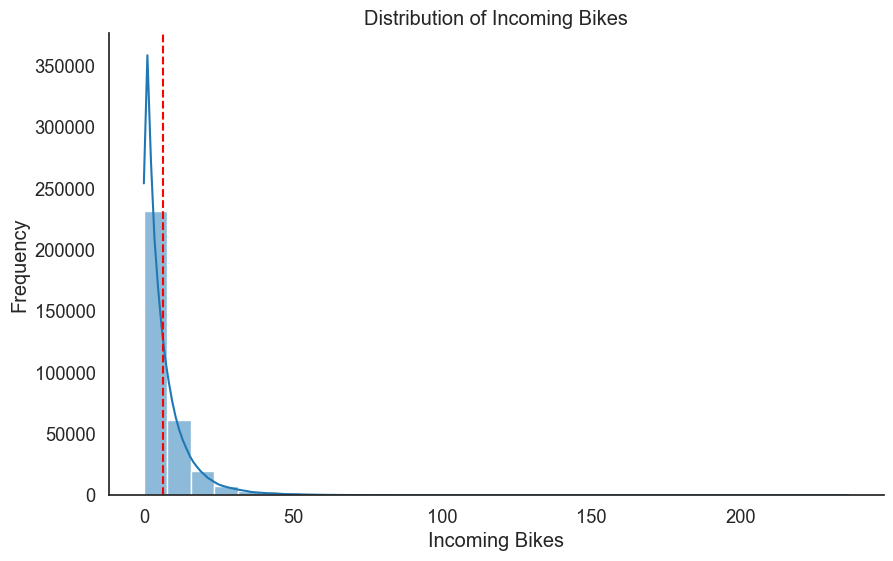

In [30]:
# plot distribution of net bikes
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2, style='white')
sns.histplot(combined_df['incoming_bikes'], bins=30, kde=True, color='tab:blue')
plt.title('Distribution of Incoming Bikes')
plt.xlabel('Incoming Bikes')
plt.ylabel('Frequency')
plt.axvline(combined_df['incoming_bikes'].abs().mean(), color='red', linestyle='--', label='Mean')
sns.despine()
plt.savefig(f'../{viz_path}incoming_bikes_distribution.png', dpi = 300, transparent = True)
plt.show()


In [32]:
# plot distribution of net bikes
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2, style='white')
sns.histplot(combined_df_encoded['log_incoming'], bins = 13,  color='tab:blue')
plt.title('Distribution of Net Bikes')
plt.xlabel('Net Bikes')
plt.ylabel('Frequency')

sns.despine()
# plt.savefig(f'../{viz_path}log_transformed_incoming_bikes.png', dpi = 300, transparent = True)
plt.show()


KeyError: 'log_incoming'

<Figure size 1000x600 with 0 Axes>

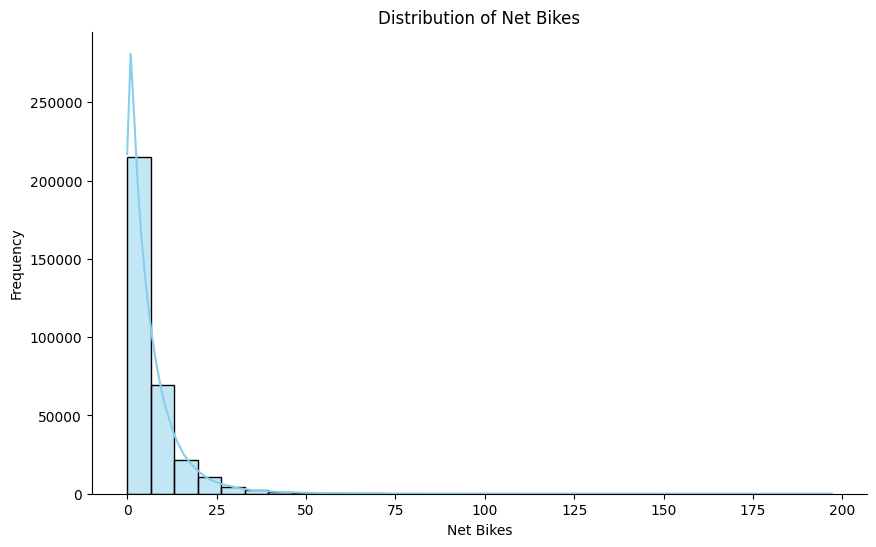

In [115]:
# plot distribution of net bikes
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['outgoing_bikes'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Net Bikes')
plt.xlabel('Net Bikes')
plt.ylabel('Frequency')
sns.despine()
plt.show()